In [1]:
# Import Libaries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import utils, preprocessing, models

import os
from zipfile import ZipFile

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import kaggle

%matplotlib inline

# Download Data

In [2]:
# Before running the code below, got your kaggle account and click on the display picture on the top-right, then click on 
# Account and in the Account page, go to API category and click on 'Create New API Token' to download .json file and save it 
# in your c:\Users\<user_name>\.kaggle  if you are running the model from PC
# OR
# https://www.kaggle.com/datasets/vuppalaadithyasairam/spine-fracture-prediction-from-xrays/code

In [3]:
!kaggle datasets download --quiet -d vuppalaadithyasairam/spine-fracture-prediction-from-xrays 

In [4]:
with ZipFile("spine-fracture-prediction-from-xrays.zip","r") as zip_obj:
    zip_obj.extractall()

In [5]:
os.listdir()

['.ipynb_checkpoints',
 'cervical fracture',
 'Cervical Fracture Modelling.ipynb',
 'Pipfile',
 'Pipfile.lock',
 'spine-fracture-prediction-from-xrays.zip']

# Data Visualization

In [6]:
train_path = "./cervical fracture/train"
test_path = "./cervical fracture/val" 

In [7]:
os.listdir(train_path), os.listdir(test_path)

(['fracture', 'normal'], ['fracture', 'normal'])

In [8]:
def visualize_data(path):
    current_dir_path = path
    
    
    for label in os.listdir(path):
        i=0
        plt.figure(figsize=(15,10))
        for image in os.listdir(path+"/"+label)[0:5]:
            img = mpimg.imread(path+"/"+label+"/"+image)
            plt.subplot(2,5,i+1)
            plt.title(label)
            plt.imshow(img)
            i=i+1
    

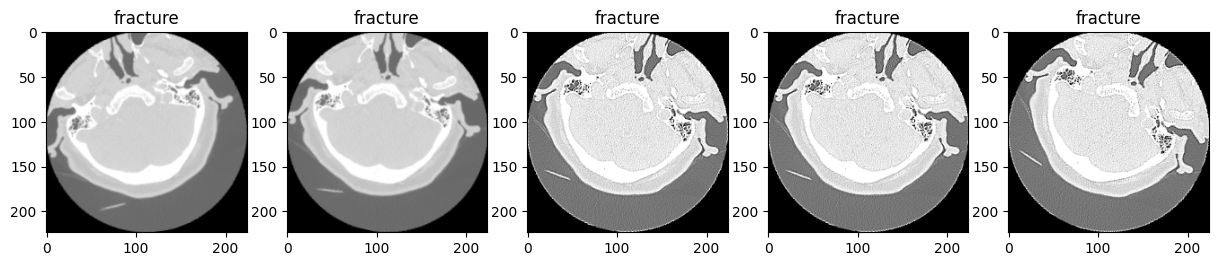

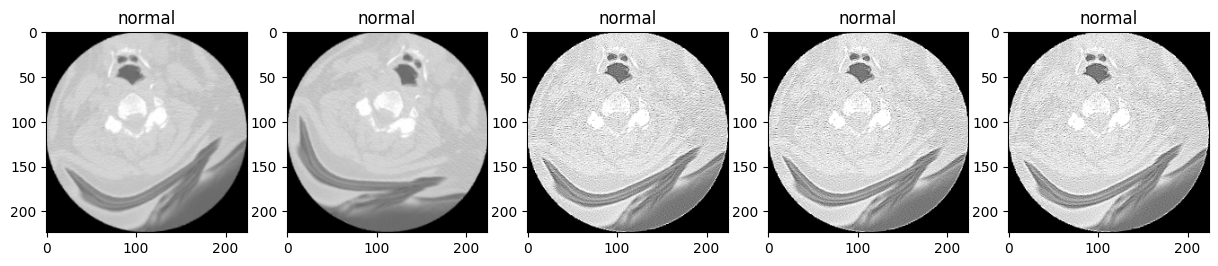

In [9]:
visualize_data(train_path) # Visualizing Training Images

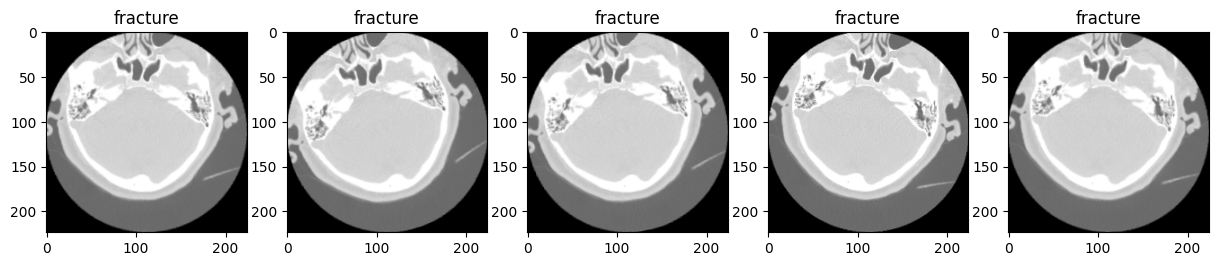

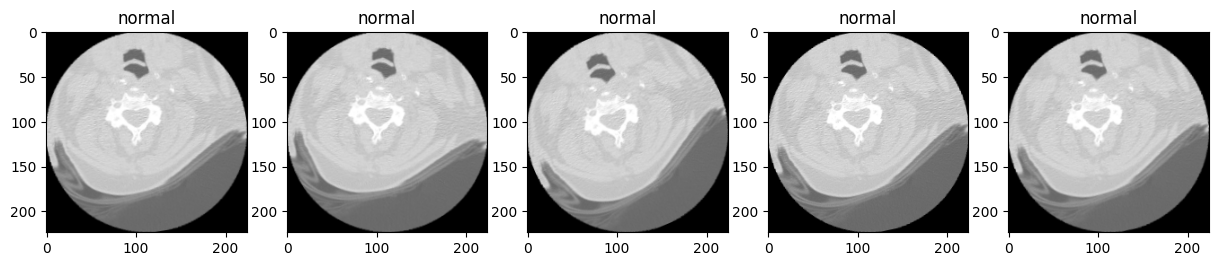

In [10]:
visualize_data(test_path) # Visualizing Evaluation Images

# Define Functions

## Load and Preprocess Data

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
### Load and Preprocess train and validation data
def load_preprocess_augment_train_val(train_path, validation_split, target_size, color_mode, class_mode, batch_size, seed ):
  
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
    
    train_generator = train_datagen.flow_from_directory(train_path, # Load Data
                                                        target_size=target_size,
                                                        color_mode=color_mode,
                                                        classes=os.listdir(train_path),
                                                        class_mode=class_mode,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        seed=seed,
                                                        subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_path, # Load Data
                                                             target_size=target_size,
                                                             color_mode=color_mode,
                                                             classes=os.listdir(train_path),
                                                             class_mode=class_mode,
                                                             batch_size=batch_size,
                                                             shuffle=True,
                                                             seed=seed,
                                                             subset='validation')
   
    return train_generator, val_generator

In [13]:
### Load and Preprocess test data

def load_preprocess_test(test_path, target_size, color_mode, class_mode, batch_size, seed):
     
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, # Load Data
                                                                            target_size=target_size,
                                                                            color_mode=color_mode,
                                                                            classes=os.listdir(test_path),
                                                                            class_mode=class_mode,
                                                                            batch_size=batch_size,
                                                                            seed=seed)
    return test_generator

## Define Model Architecture

### Define Custom Architecture

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, InputLayer, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization


In [15]:
def custom_model(input_shape, kernel_size, pool_size, output_activation, dense_layer_1_neurons):
    
    
    
    custom_model = Sequential([InputLayer(input_shape=input_shape),
 
                              Conv2D(filters=64, kernel_size=kernel_size, 
                                     strides=(2, 2) , activation='relu'),
 
                              Conv2D(filters=32, kernel_size=kernel_size, 
                                     strides=(2, 2) , activation='relu'),
                              
                              Dropout(0.2),
                               
                              BatchNormalization(), 
                               
                              MaxPool2D(pool_size=pool_size),
                               
                              Flatten(),
 
                              Dense(units=dense_layer_1_neurons , activation='relu'),
                                                                                        
                              Dense(units=1, activation=output_activation)], name="Custom_model")
    
    print(custom_model.summary())
    
    return custom_model

In [16]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Resizing

In [17]:
### Use Pre-trained Models and Show Model Summary 
def pretrained_model(pre_trained_model, pretrained_model_name):
      
    base_model = pre_trained_model
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))

    x = base_model(inputs, training=False)
        
    x = GlobalAveragePooling2D()(x)
    
    outputs = Dense(1,activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name=pretrained_model_name)
    
    print(model.summary())
    
    return model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [19]:
## Compile and Train Model
def train_model(models_list, train_generator, val_generator, epochs):
            
    trained_models_list =[]
    train_val_history_obj_list = []
    
#     
    
    for model_name, model in models_list:
        
        filepath=f'best_models/{model_name}.h5'
        
        rlrp = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2)
        checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')

        callback = [checkpoint,rlrp]
         
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
        
        train_val_history_obj_list.append(model.fit_generator(train_generator, epochs=epochs, 
                                                              validation_data=val_generator, shuffle=True,
                                                               callbacks=callback))
        
        trained_models_list.append((model_name, model))
        
         
    return trained_models_list, train_val_history_obj_list

In [20]:
# Evaluate Model
def eval_model(trained_models_list, test_generator):
    eval_history_obj_list = [model[1].evaluate(test_generator, return_dict=True) for model in trained_models_list]
    
    return eval_history_obj_list

In [21]:
# Model Pipeline
def model_pipeline(models_list):
    
    trained_models_pred_list =[]
    best_models = []
    best_models_pred_list =[]

    
    # Load and Preprocess Data
    train_generator, val_generator = load_preprocess_augment_train_val(train_path, validation_split, target_size, 
                                                                         color_mode, class_mode, batch_size, seed)
    print(f"Train Classes index:  {train_generator.class_indices}\n")
    
    test_generator = load_preprocess_test(test_path, target_size, color_mode, class_mode, batch_size, seed)
    
    print(f"Test Classes index:  {test_generator.class_indices}\n")
     
    # Train Models
    trained_models_list, train_val_history_obj_list = train_model(models_list, train_generator, val_generator, epochs) 
    
    print()
    
    # Evaluate Models
    eval_results_list = eval_model(trained_models_list, test_generator) 

    print("\n\n")
    
    dataset_list = [train_generator, val_generator, test_generator]
    
    for model_name, model in trained_models_list:
        trained_models_pred_list.append([(model.predict(train_generator)>0.5).astype('int32'), 
                                         (model.predict(val_generator)>0.5).astype('int32'),
                                         (model.predict(test_generator)>0.5).astype('int32')])
      
    
    for file_name in os.listdir(os.getcwd()+"\\best_models"):
        if file_name.endswith('.h5'):
            best_models.append((file_name[0:-3],tf.keras.models.load_model(os.getcwd()+"\\best_models\\"+file_name)))

    for model_name, model in best_models:
        best_models_pred_list.append([(model.predict(train_generator)>0.5).astype('int32'), 
                                      (model.predict(val_generator)>0.5).astype('int32'), 
                                      (model.predict(test_generator)>0.5).astype('int32')])

    
    return trained_models_list, train_val_history_obj_list, eval_results_list, dataset_list, trained_models_pred_list, best_models, best_models_pred_list 

# Parameters

In [22]:
# Load and Preprocess Parameters
train_path = "./cervical fracture/train"
test_path = "./cervical fracture/val" 
target_size=(224, 224)
color_mode="rgb"
class_mode='binary'
batch_size=16
seed=100
validation_split=0.20

# Custom Model Parameters
input_shape = (224, 224, 3)
kernel_size = (3, 3)
pool_size = (2, 2)
output_activation = 'sigmoid'
dense_layer_1_neurons = 64

# Model Compilation Parameters
learning_rate = 0.001
metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
loss_fn = 'binary_crossentropy'
optimizer = 'SGD' 

## Parameters to Train and Evaluate Model
epochs = 20

## Pre-trained Models List for Training

In [23]:
from tensorflow.keras.applications import InceptionV3 
from tensorflow.keras.applications.resnet_v2 import ResNet50V2  
from tensorflow.keras.applications.xception import Xception

models_list =[]

models_list.append(("Custom Model", 
                   custom_model(input_shape, kernel_size, pool_size,output_activation, 
                                dense_layer_1_neurons)))

print("\n")

models_list.append(("Pre-trained - Inception_v3", 
                    pretrained_model(InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape),
                                    "Inception_v3")))

print("\n")


models_list.append(("Pre-trained - ResNet50V2", 
                    pretrained_model(ResNet50V2(include_top=False, weights='imagenet',input_shape=input_shape),
                                     "ResNet50V2")))

print("\n")
               
models_list.append(("Pre-trained - Xception", 
                    pretrained_model(Xception(include_top=False, weights='imagenet',input_shape=input_shape),
                                     "Xception")))

Model: "Custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 111, 111, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 32)        18464     
                                                                 
 dropout (Dropout)           (None, 55, 55, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 23328)            

# Run Models

In [24]:
trained_models_list, train_val_history_obj_list, eval_results_list, dataset_list, trained_models_pred_list, best_models, best_models_pred_list  =  model_pipeline(models_list)

Found 3040 images belonging to 2 classes.
Found 760 images belonging to 2 classes.
Train Classes index:  {'fracture': 0, 'normal': 1}

Found 400 images belonging to 2 classes.
Test Classes index:  {'fracture': 0, 'normal': 1}



C:\Users\Praveen\AppData\Local\Temp\ipykernel_19396\4108962659.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_val_history_obj_list.append(model.fit_generator(train_generator, epochs=epochs,


Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9461 - precision: 0.9637 - recall: 0.9270
Epoch 00001: val_accuracy improved from -inf to 0.81053, saving model to best_models\Custom Model.h5
190/190 [==============================] - 38s 196ms/step - loss: 0.1538 - accuracy: 0.9461 - precision: 0.9637 - recall: 0.9270 - val_loss: 0.4664 - val_accuracy: 0.8105 - val_precision: 0.7252 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980
Epoch 00002: val_accuracy improved from 0.81053 to 0.84737, saving model to best_models\Custom Model.h5
190/190 [==============================] - 32s 167ms/step - loss: 0.0115 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - val_loss: 0.2974 - val_accuracy: 0.8474 - val_precision: 0.7661 - val_recall: 1.0000 - lr: 0.0100
Epoch 3/20
190/190 [==============================] - ETA: 0s - loss: 0

190/190 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 00020: val_accuracy did not improve from 0.91053
190/190 [==============================] - 31s 163ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1862 - val_accuracy: 0.9026 - val_precision: 0.8370 - val_recall: 1.0000 - lr: 1.0000e-09
Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9609 - precision: 0.9415 - recall: 0.9579
Epoch 00001: val_accuracy improved from -inf to 0.80395, saving model to best_models\Pre-trained - Inception_v3.h5
190/190 [==============================] - 122s 621ms/step - loss: 0.1354 - accuracy: 0.9609 - precision: 0.9415 - recall: 0.9579 - val_loss: 0.4543 - val_accuracy: 0.8039 - val_precision: 0.7401 - val_recall: 0.9368 - lr: 0.0100
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9980 - precision: 0.9

Epoch 19/20
190/190 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9993 - precision: 0.9987 - recall: 1.0000
Epoch 00019: val_accuracy did not improve from 0.83289
190/190 [==============================] - 150s 792ms/step - loss: 0.0120 - accuracy: 0.9993 - precision: 0.9987 - recall: 1.0000 - val_loss: 0.4081 - val_accuracy: 0.8329 - val_precision: 0.7641 - val_recall: 0.9632 - lr: 1.0000e-09
Epoch 20/20
190/190 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9993 - precision: 0.9987 - recall: 1.0000
Epoch 00020: val_accuracy did not improve from 0.83289
190/190 [==============================] - 169s 891ms/step - loss: 0.0120 - accuracy: 0.9993 - precision: 0.9987 - recall: 1.0000 - val_loss: 0.4081 - val_accuracy: 0.8329 - val_precision: 0.7641 - val_recall: 0.9632 - lr: 1.0000e-09
Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9770 - precision: 0.9298 - recall: 0.9695
Epoch 00001: val_accu

C:\Users\Praveen\.virtualenvs\Capstone_#1-oWjiKTpQ\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


190/190 [==============================] - 251s 1s/step - loss: 0.1019 - accuracy: 0.9770 - precision: 0.9298 - recall: 0.9695 - val_loss: 0.3513 - val_accuracy: 0.8118 - val_precision: 0.7443 - val_recall: 0.9500 - lr: 0.0100
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9987
Epoch 00002: val_accuracy improved from 0.81184 to 0.83289, saving model to best_models\Pre-trained - ResNet50V2.h5
190/190 [==============================] - 198s 1s/step - loss: 0.0250 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9987 - val_loss: 0.3193 - val_accuracy: 0.8329 - val_precision: 0.7576 - val_recall: 0.9789 - lr: 0.0100
Epoch 3/20
190/190 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 00003: val_accuracy improved from 0.83289 to 0.85395, saving model to best_models\Pre-trained - ResNet50V2.h5
190/190 [==============================] - 219s 

Epoch 1/20
190/190 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9490 - precision: 0.9211 - recall: 0.9405
Epoch 00001: val_accuracy improved from -inf to 0.81711, saving model to best_models\Pre-trained - Xception.h5
190/190 [==============================] - 245s 1s/step - loss: 0.2128 - accuracy: 0.9490 - precision: 0.9211 - recall: 0.9405 - val_loss: 0.3226 - val_accuracy: 0.8171 - val_precision: 0.7495 - val_recall: 0.9526 - lr: 0.0100
Epoch 2/20
190/190 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9905 - precision: 0.9908 - recall: 0.9901
Epoch 00002: val_accuracy improved from 0.81711 to 0.82500, saving model to best_models\Pre-trained - Xception.h5
190/190 [==============================] - 255s 1s/step - loss: 0.0881 - accuracy: 0.9905 - precision: 0.9908 - recall: 0.9901 - val_loss: 0.3023 - val_accuracy: 0.8250 - val_precision: 0.7589 - val_recall: 0.9526 - lr: 0.0100
Epoch 3/20
190/190 [==============================] - E

Epoch 20/20
190/190 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9993
Epoch 00020: val_accuracy did not improve from 0.84474
190/190 [==============================] - 227s 1s/step - loss: 0.0187 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9993 - val_loss: 0.2740 - val_accuracy: 0.8408 - val_precision: 0.7681 - val_recall: 0.9763 - lr: 1.0000e-07

25/25 [==============================] - 23s 902ms/step - loss: 0.3932 - accuracy: 0.8350 - precision: 0.8221 - recall: 0.8550





# Visualizing Training, Validation and Test Results

In [25]:
model_names = [model[0] for model in models_list]

In [47]:
import pandas as pd

In [83]:
def plot_metrics(model_names, train_val_history_obj_list, eval_results_list):
    
    ## Accuracy
    plt.figure(figsize=(10, 5))
    
    legend = []
 
    for model_name, model_history in zip(model_names, train_val_history_obj_list):
        
        accuracy = pd.Series(model_history.history['accuracy'])
        val_accuracy = pd.Series(model_history.history['val_accuracy'])
        
        accuracy.plot()
        legend.append(f'{model_name} - Train Accuracy')

        val_accuracy.plot(linestyle="dashed") 
        legend.append(f'{model_name} - Val Accuracy')
        
    plt.title(f"Trained Models - Train Accuracy and Validation Accuracy vs  Epochs")
    plt.legend(labels=legend, bbox_to_anchor=(1, 0.5, 0, 0.5))
    plt.show()
    
    
    ## Loss
    plt.figure(figsize=(10, 5))
    
    legend = []
    
    for model_name, model_history in zip(model_names, train_val_history_obj_list):
        
        loss = pd.Series(model_history.history['loss'])
        val_loss = pd.Series(model_history.history['val_loss'])
        
        loss.plot()
        legend.append(f'{model_name} - Train Loss')

        val_loss.plot(linestyle="dashed")
        legend.append(f'{model_name} - Val Loss')
        
         
    plt.title(f"Trained Models - Train Loss and Validation Loss vs  Epochs")
    plt.legend(labels=legend, bbox_to_anchor=(1, 0.5, 0, 0.5))
    plt.show()
    
    
    
    ## Precision
    plt.figure(figsize=(10, 5))
    
    legend = []
 
    for model_name, model_history in zip(model_names, train_val_history_obj_list):
        
        precision = pd.Series(model_history.history['precision'])
        val_precision = pd.Series(model_history.history['val_precision'])
        
        precision.plot()
        legend.append(f'{model_name} - Train Precision')

        val_precision.plot(linestyle="dashed")
        legend.append(f'{model_name} - Val Precision')
        
    plt.title(f"Trained Models - Train Precision and Validation Precision vs  Epochs")
    plt.legend(labels=legend, bbox_to_anchor=(1, 0.5, 0, 0.5))
    plt.show()
    
    
    ## Recall
    plt.figure(figsize=(10, 5))
    
    legend = []
 
    for model_name, model_history in zip(model_names, train_val_history_obj_list):
        
        recall = pd.Series(model_history.history['recall'])
        val_recall = pd.Series(model_history.history['val_recall'])
        
        recall.plot()
        legend.append(f'{model_name} - Train Recall')

        val_recall.plot(linestyle="dashed")
        legend.append(f'{model_name} - Val Recall')
        
    plt.title(f"Trained Models - Train Recall and Validation Recall vs  Epochs")
    plt.legend(labels=legend, bbox_to_anchor=(1, 0.5, 0, 0.5))
    plt.show()
    
    
    
    
    ## Test Metrics
    
    
    test_metrics =pd.DataFrame({'loss': [eval_dict['loss']for eval_dict in eval_results_list],
                               'accuracy': [eval_dict['accuracy']for eval_dict in eval_results_list],
                               'precision': [eval_dict['precision']for eval_dict in eval_results_list],
                               'recall': [eval_dict['recall']for eval_dict in eval_results_list]
                              }, index=model_names ) 

    test_metrics.plot(figsize=(15, 5))
    plt.title(f"Trained Models vs their Test Data loss and accuracy")
    plt.legend(labels=['Test Loss', 'Test Accuracy','Test Precision', 'Test Recall' ], bbox_to_anchor=(1, 0.5, 0, 0.5))
    plt.show()

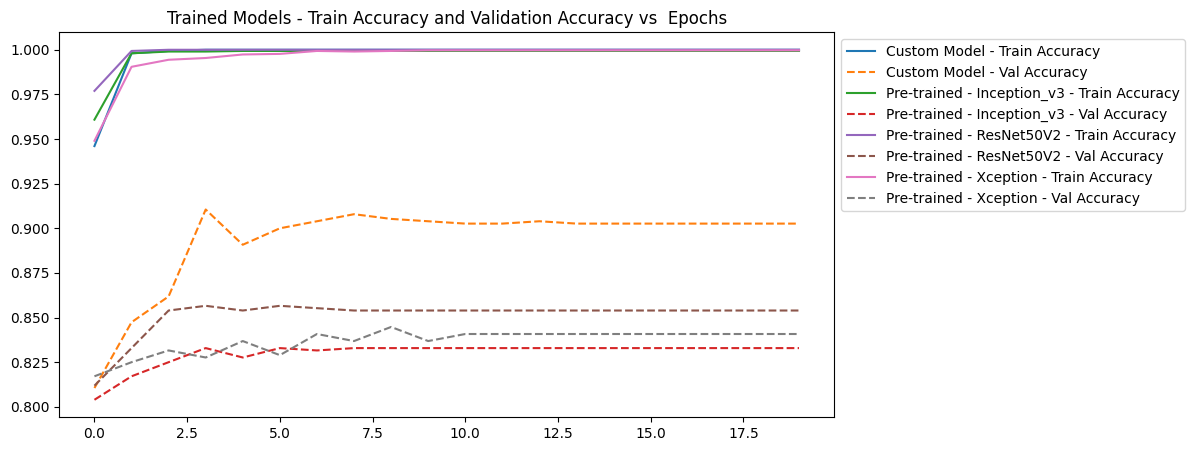

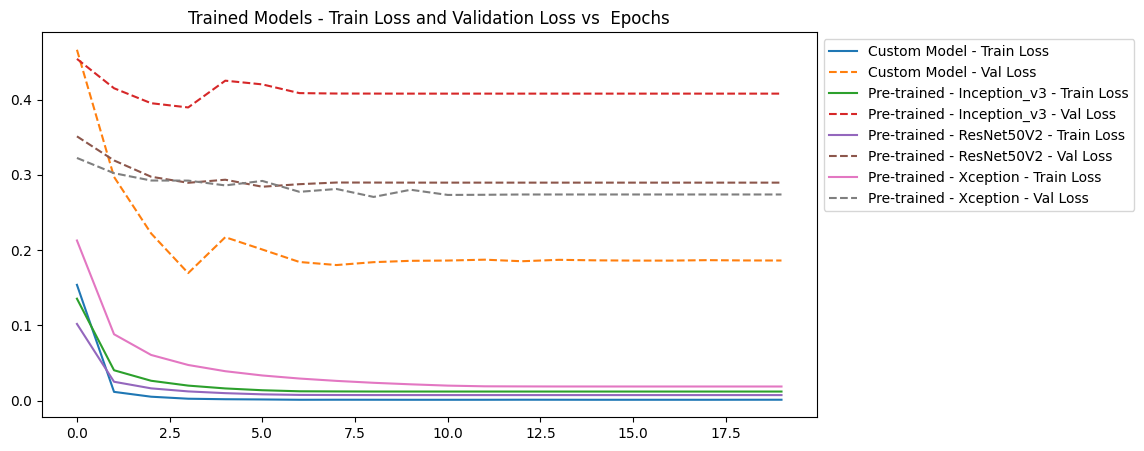

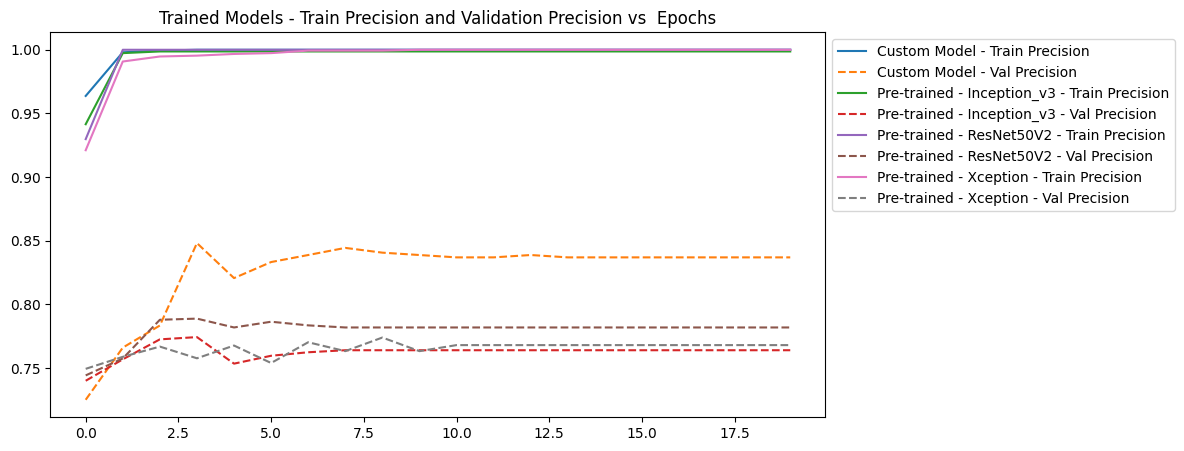

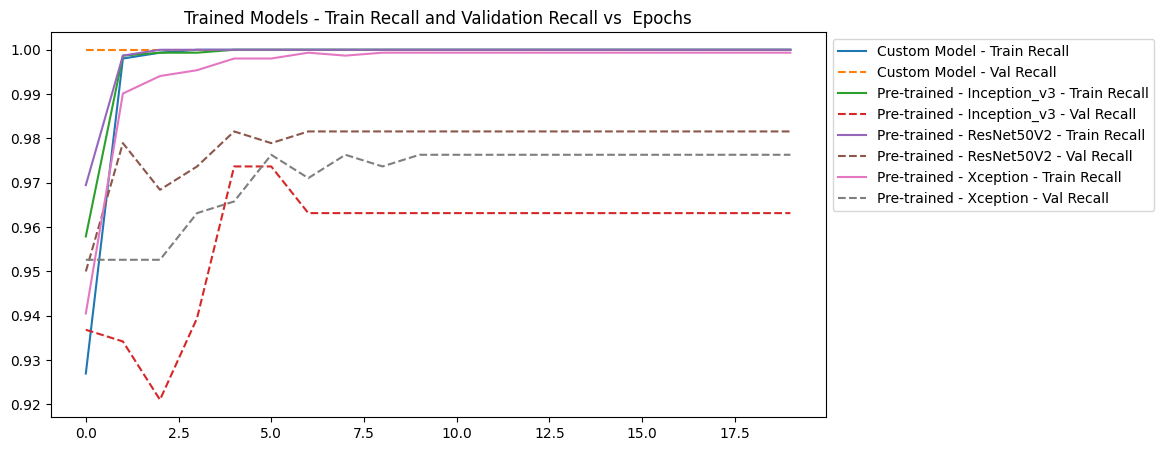

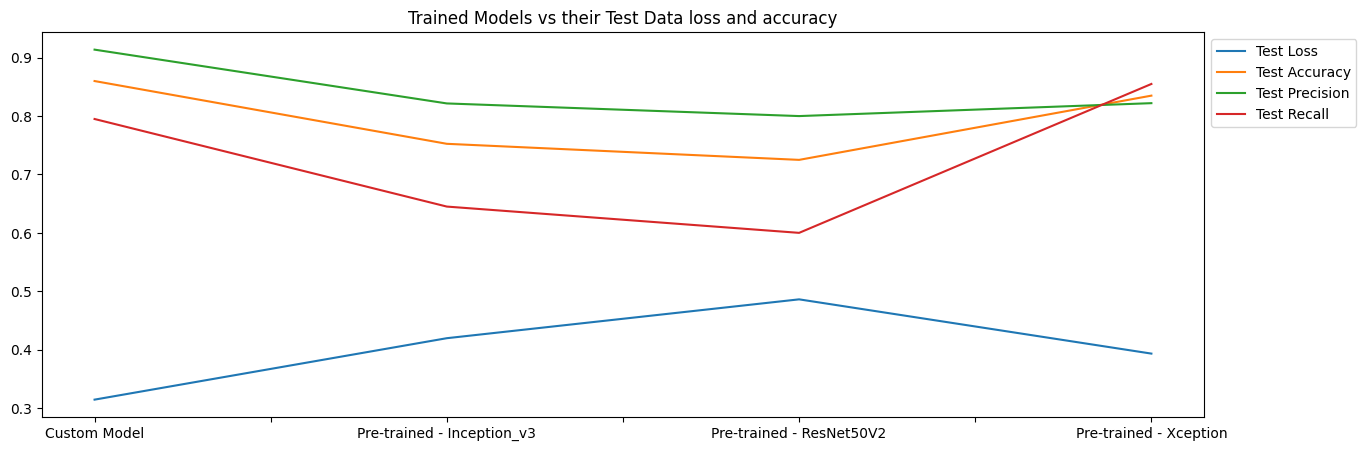

In [84]:
plot_metrics(model_names, train_val_history_obj_list, eval_results_list)

# Define Visualization Functions - Model Predictions

### Confusion Matrix

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_plot(model_name, dataset_list, pred_list):   

    titles=["Train", "Validation","Test"]
    cm_list = []
    labels=[key.capitalize() for key in dataset_list[0].class_indices.keys()]
 

    for i, data in enumerate(dataset_list):   
        cm_list.append(confusion_matrix(y_true=data.labels,
                                        y_pred= pred_list[i],
                                        labels=list(data.class_indices.values()),
                                        normalize=None))
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(18,6), layout='tight')

    plt.suptitle(model_name, y=1, fontsize=12, fontweight='bold')
    
    ax0.set_title(titles[0] + " - Confusion Matrix")
    ax0.tick_params(axis='y', labelrotation=90)
    disp0 = ConfusionMatrixDisplay(confusion_matrix=cm_list[0], display_labels= ['Fracture', 'Normal'])
    disp0.plot(ax=ax0, colorbar=False, cmap='Blues')
        
    ax1.set_title(titles[1] + " - Confusion Matrix") 
    ax1.tick_params(axis='y', labelrotation=90)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_list[1], display_labels= ['Fracture', 'Normal'])
    disp1.plot(ax=ax1, colorbar=False, cmap='Blues')
    
    ax2.set_title(titles[2] + " - Confusion Matrix")  
    ax2.tick_params(axis='y', labelrotation=90)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_list[2], display_labels= ['Fracture', 'Normal'])
    disp2.plot(ax=ax2, colorbar=False, cmap='Blues')
    plt.show()
    
    print()
    
 

## Visualize Results using Confusion Matrix  

### Best Models' confusion matrix

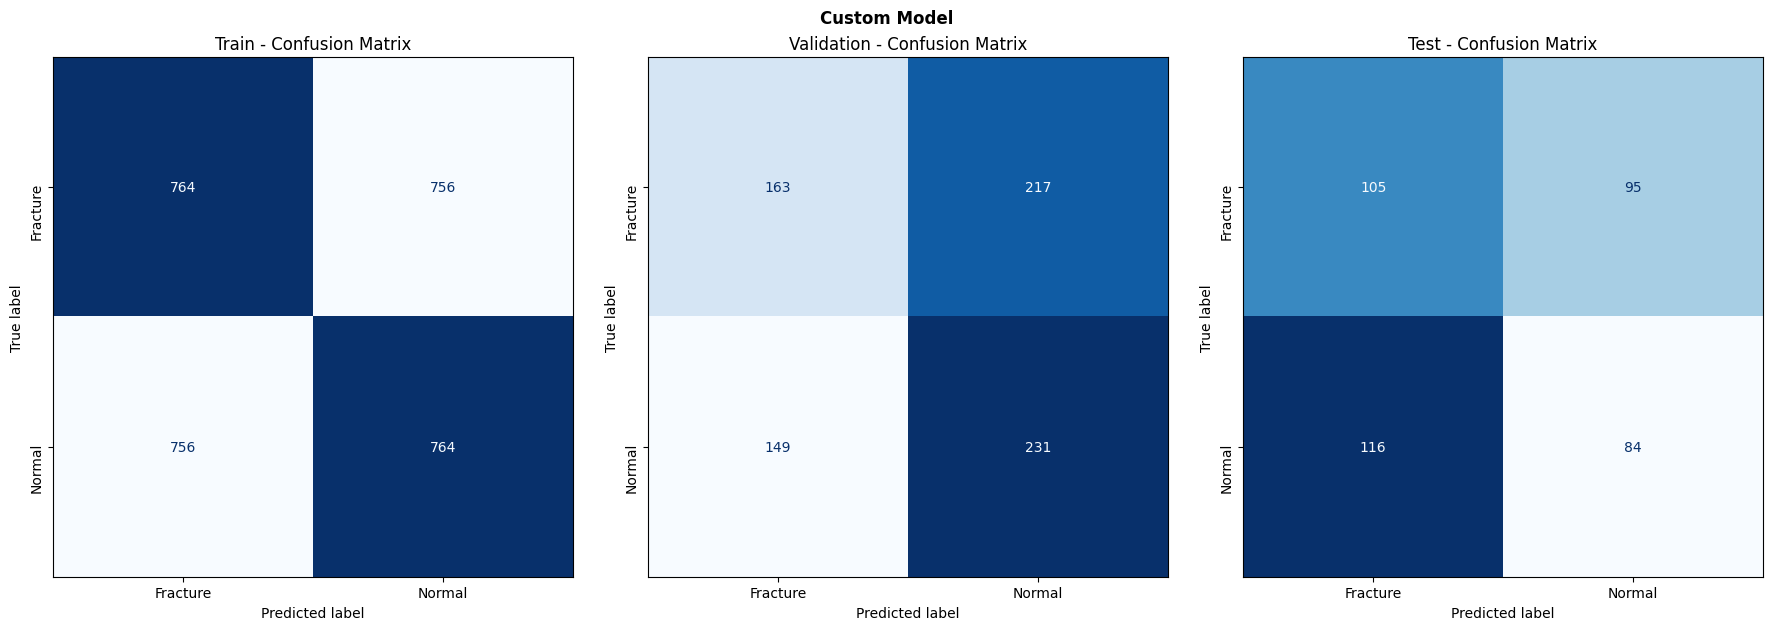

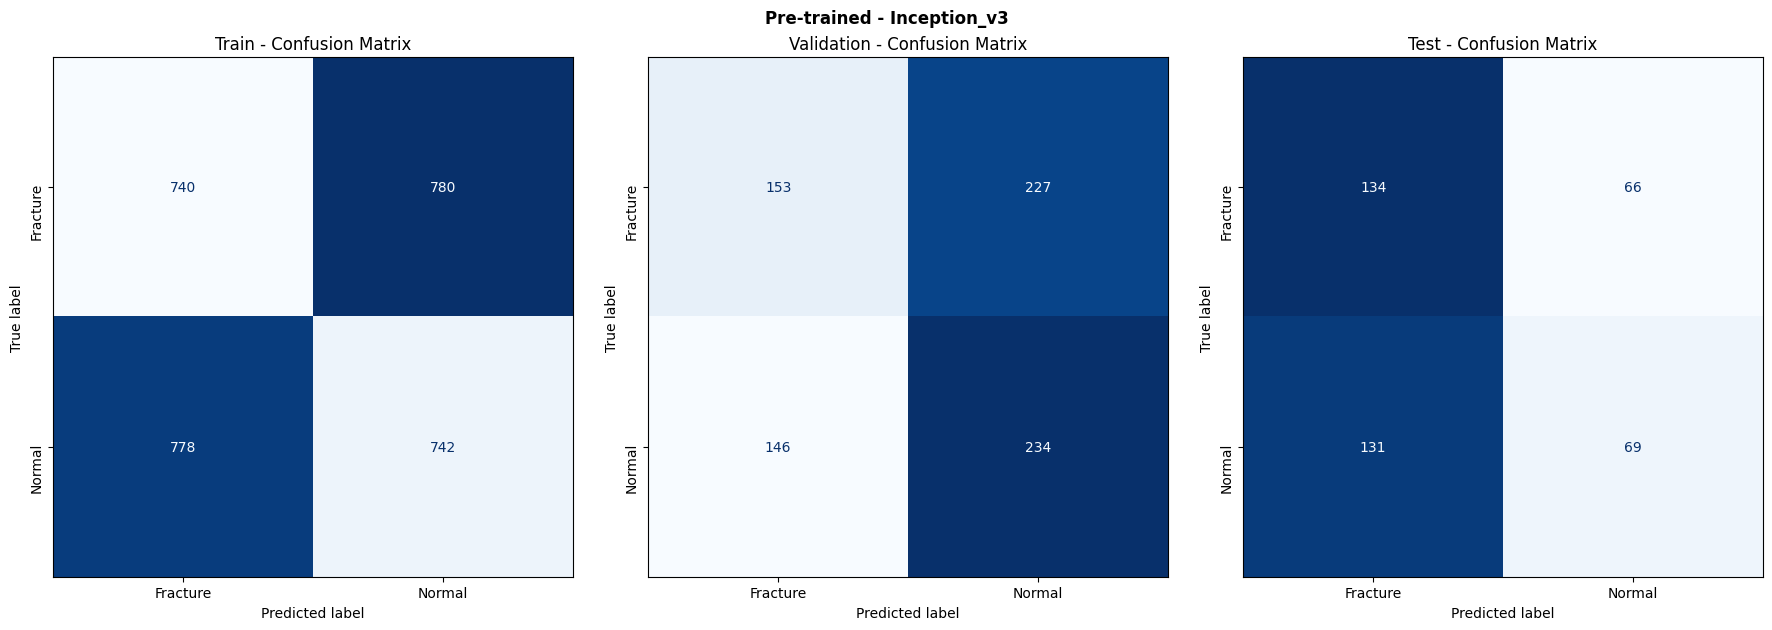

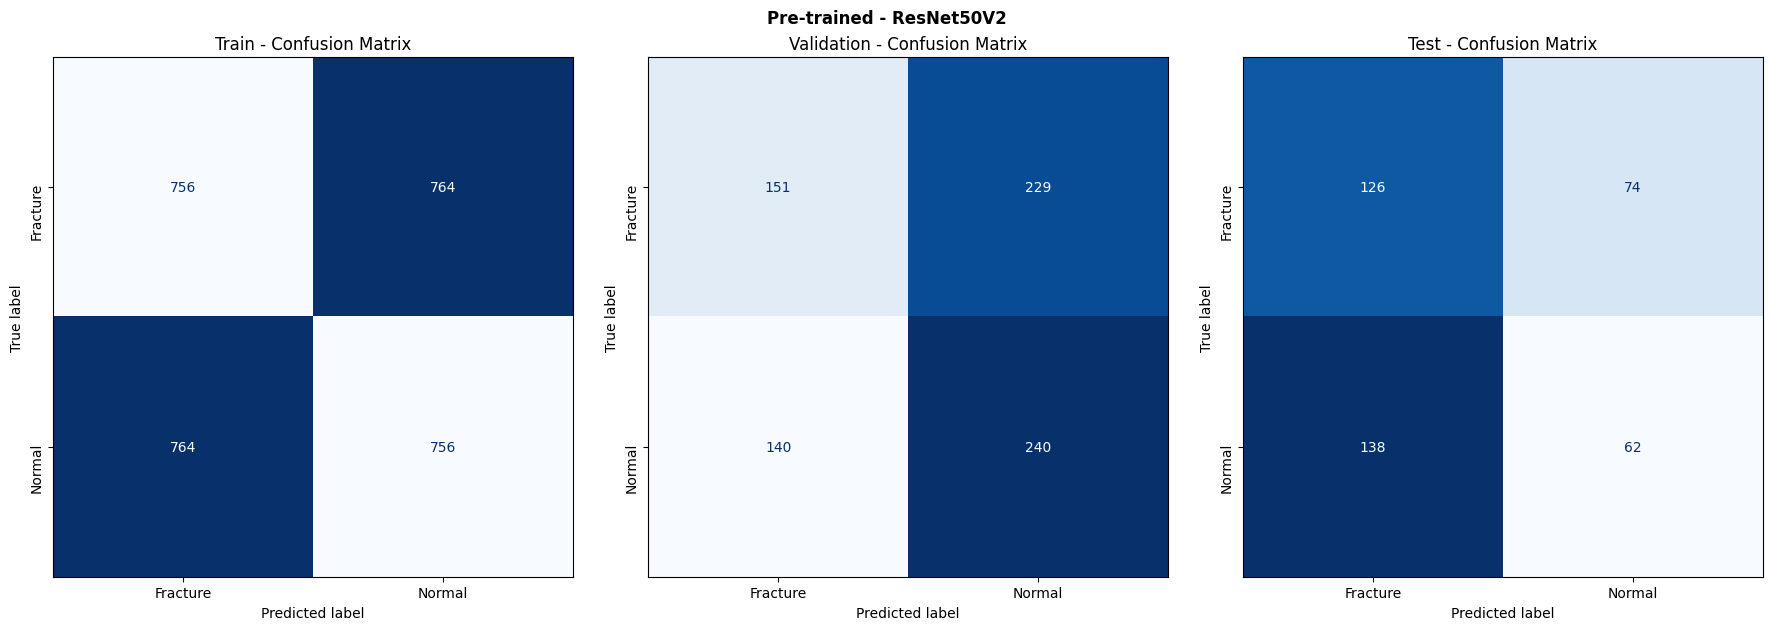

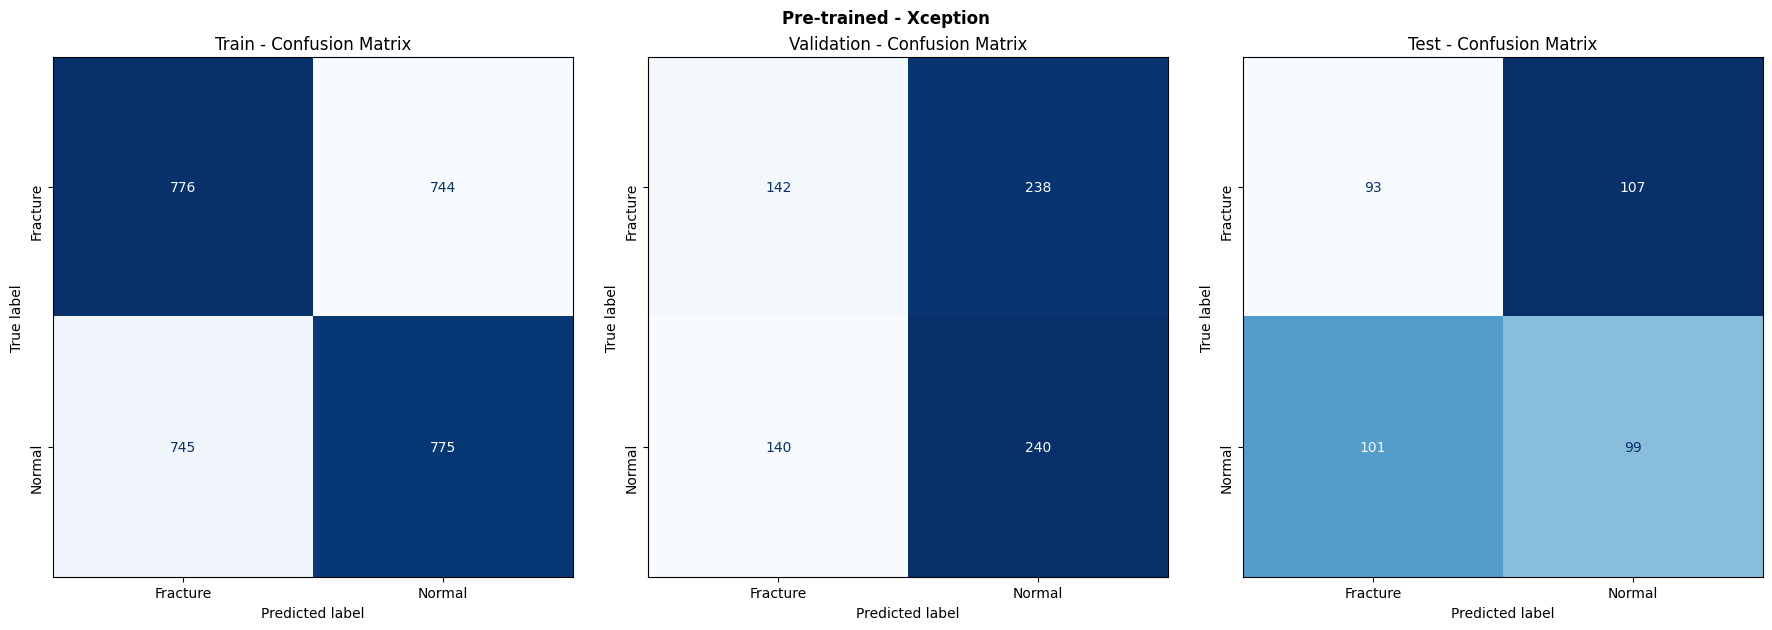

In [92]:
for classifier, pred_list in zip(best_models, best_models_pred_list):
    confusion_matrix_plot(classifier[0], dataset_list, pred_list)

In [98]:
 ### Fully Trained(20 epochs) Models' Confusion Matrix

In [99]:
# for classifier, pred_list in zip(trained_models_list, trained_models_pred_list):
#     confusion_matrix_plot(classifier[0], dataset_list, pred_list)

***Custom model.h5' has had metrics when training and validation It performs better than other models even with the Test data in terms of accuracy and loss.***

 
At Epoch 00004: val_accuracy improved from 0.86184 to 0.91053 <br>
loss: 0.0024 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 <br>
val_loss: 0.1695 - val_accuracy: 0.9105 - val_precision: 0.8482 - val_recall: 1.0000 - lr: 0.0100

In [101]:
cervical_fracture_model = tf.keras.models.load_model("./best_models/Custom Model.h5")

## Visualize Predicitions

In [119]:
def visualize_prediction(model, path, data_used):

    current_dir_path = path
    for label in os.listdir(path):
        dir_name = os.path.basename(path)
 
        i=0
        plt.figure(figsize=(20,10))
        plt.title(data_used)

        for image in os.listdir(path+"/"+label)[0:5]:
            img = mpimg.imread(path+"/"+label+"/"+image)
            
            pred_proba = round(model.predict(np.array([img]))[0][0], 4)
            pred = np.where(pred_proba>=0.5, "normal", "fracture")
            
            plt.subplot(2,5,i+1)
            
            if(pred == label):
                plt.title(f"Pred: {pred}\n Prob: {pred_proba} \nTrue: {label}")
            else:
                plt.title(f"Pred: {pred}\n Prob: {pred_proba} \nTrue: {label}",  color='red' )
            
            i=i+1 
            plt.xticks([])
            plt.yticks([])
            plt.imshow(img)
            
        plt.savefig(f"Custom_Deep_CNN_{dir_name}_image_predictions")

### Predicting using the final model on Train Images

C:\Users\Praveen\AppData\Local\Temp\ipykernel_19396\3543099894.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


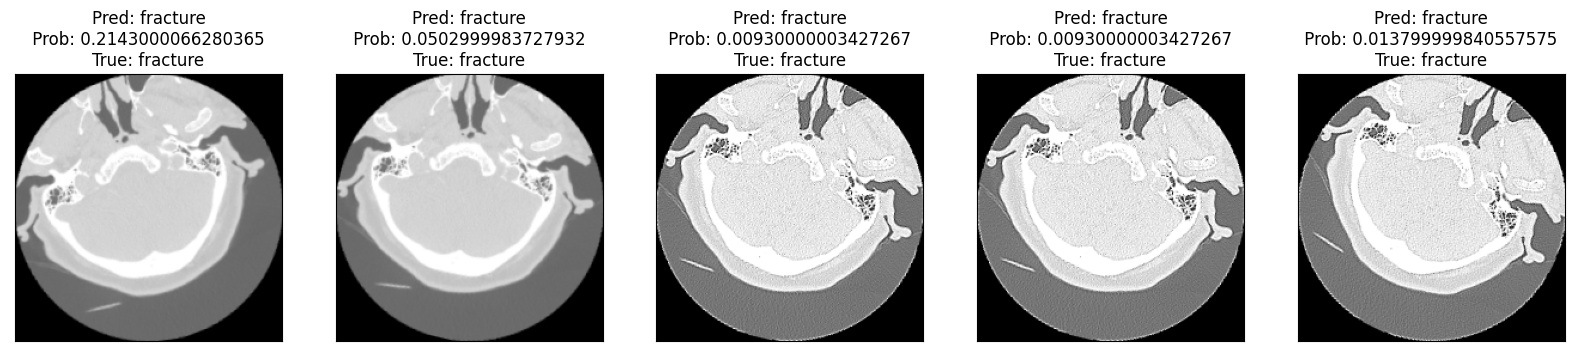

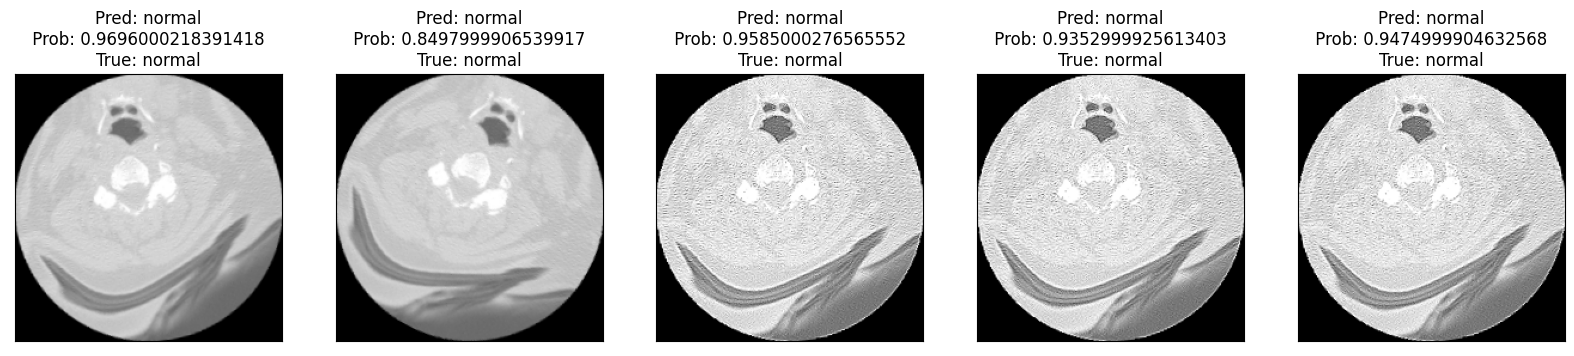

In [120]:
visualize_prediction(cervical_fracture_model, train_path, "Train Images")

#### Predicting using the final model on Test Images

C:\Users\Praveen\AppData\Local\Temp\ipykernel_19396\3543099894.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


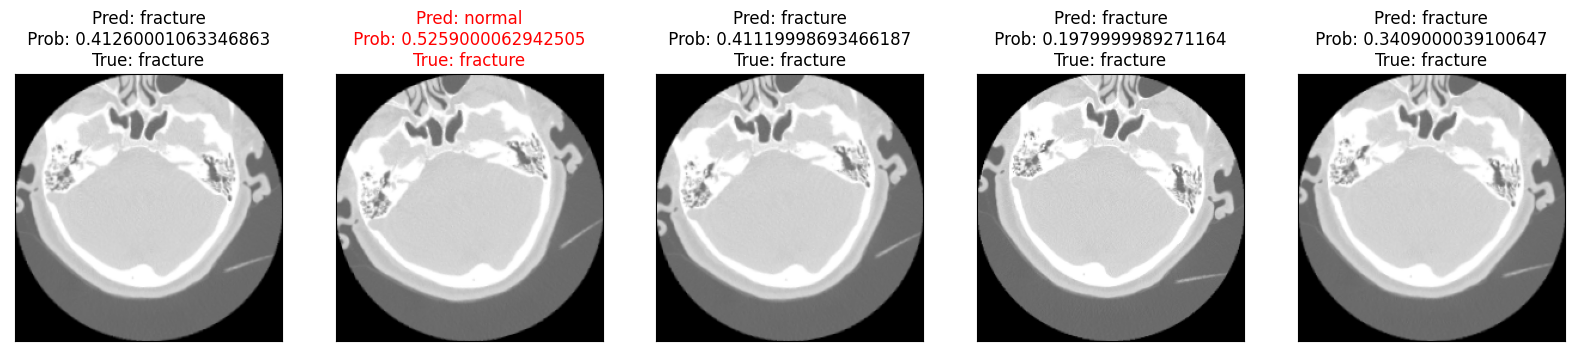

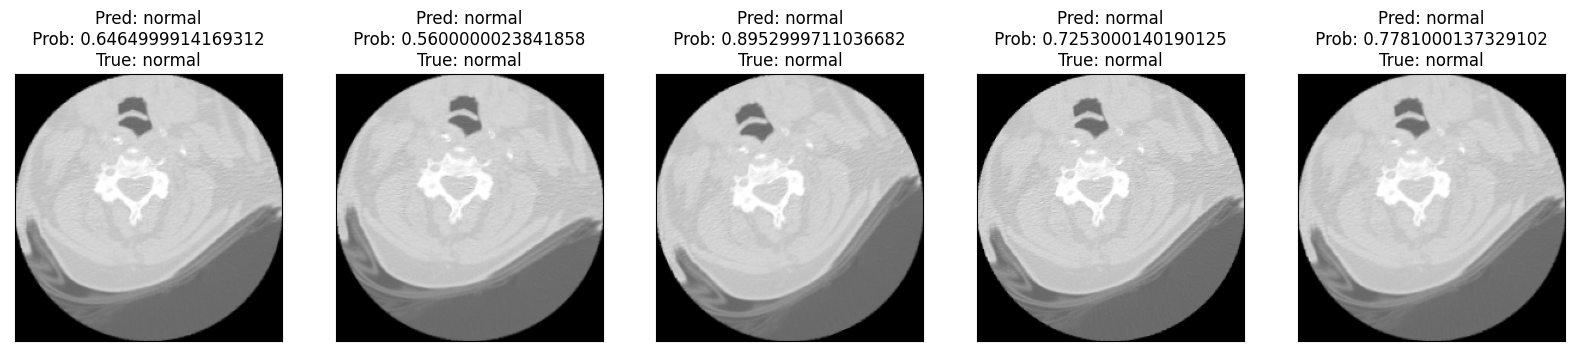

In [121]:
visualize_prediction(cervical_fracture_model, test_path, "Test Images")

In [123]:
tf.keras.models.save_model(cervical_fracture_model,'cerv_fracture_model.h5')